## EfficientNet B6 - min exposure

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

c:\users\endre\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\endre\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\endre\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

t = [None] * 10
for i in range(0,10):
  t[i] = pd.read_csv("test_set_"+str(i)+".csv")
  
print("Accuracy score pr fold")     
for i in range(0,10):
  print(accuracy_score(t[i].y_pred_test_rounded, t[i].y_true), end = ', ')
print("")

print("MSE pr fold")  
for i in range(0,10):
  print(mean_squared_error(t[i].y_pred_test, t[i].y_true), end = ', ')   
print("")
  
aggregate_pred = t[0].y_pred_test.values
for i in range(1,10):
  aggregate_pred += t[i].y_pred_test.values

aggregate_pred = aggregate_pred/10.0
print(str( accuracy_score(aggregate_pred.round().astype("int"), t[0].y_true) ) + " "+ 
      str( mean_squared_error(aggregate_pred, t[0].y_true) ) ) 


Accuracy score pr fold
0.6854368932038835, 0.7242718446601941, 0.7436893203883496, 0.6912621359223301, 0.7281553398058253, 0.6990291262135923, 0.6718446601941748, 0.6699029126213593, 0.7106796116504854, 0.7048543689320388, 
MSE pr fold
0.2982155087004419, 0.2795556005913096, 0.25220968954607903, 0.28771123868487125, 0.2718408566985495, 0.30365938112605206, 0.3218095223742313, 0.3381657830641707, 0.28909193866070293, 0.3105652273334211, 
0.7300970873786408 0.25840035465797506


### Boxplot of prediction pr age class

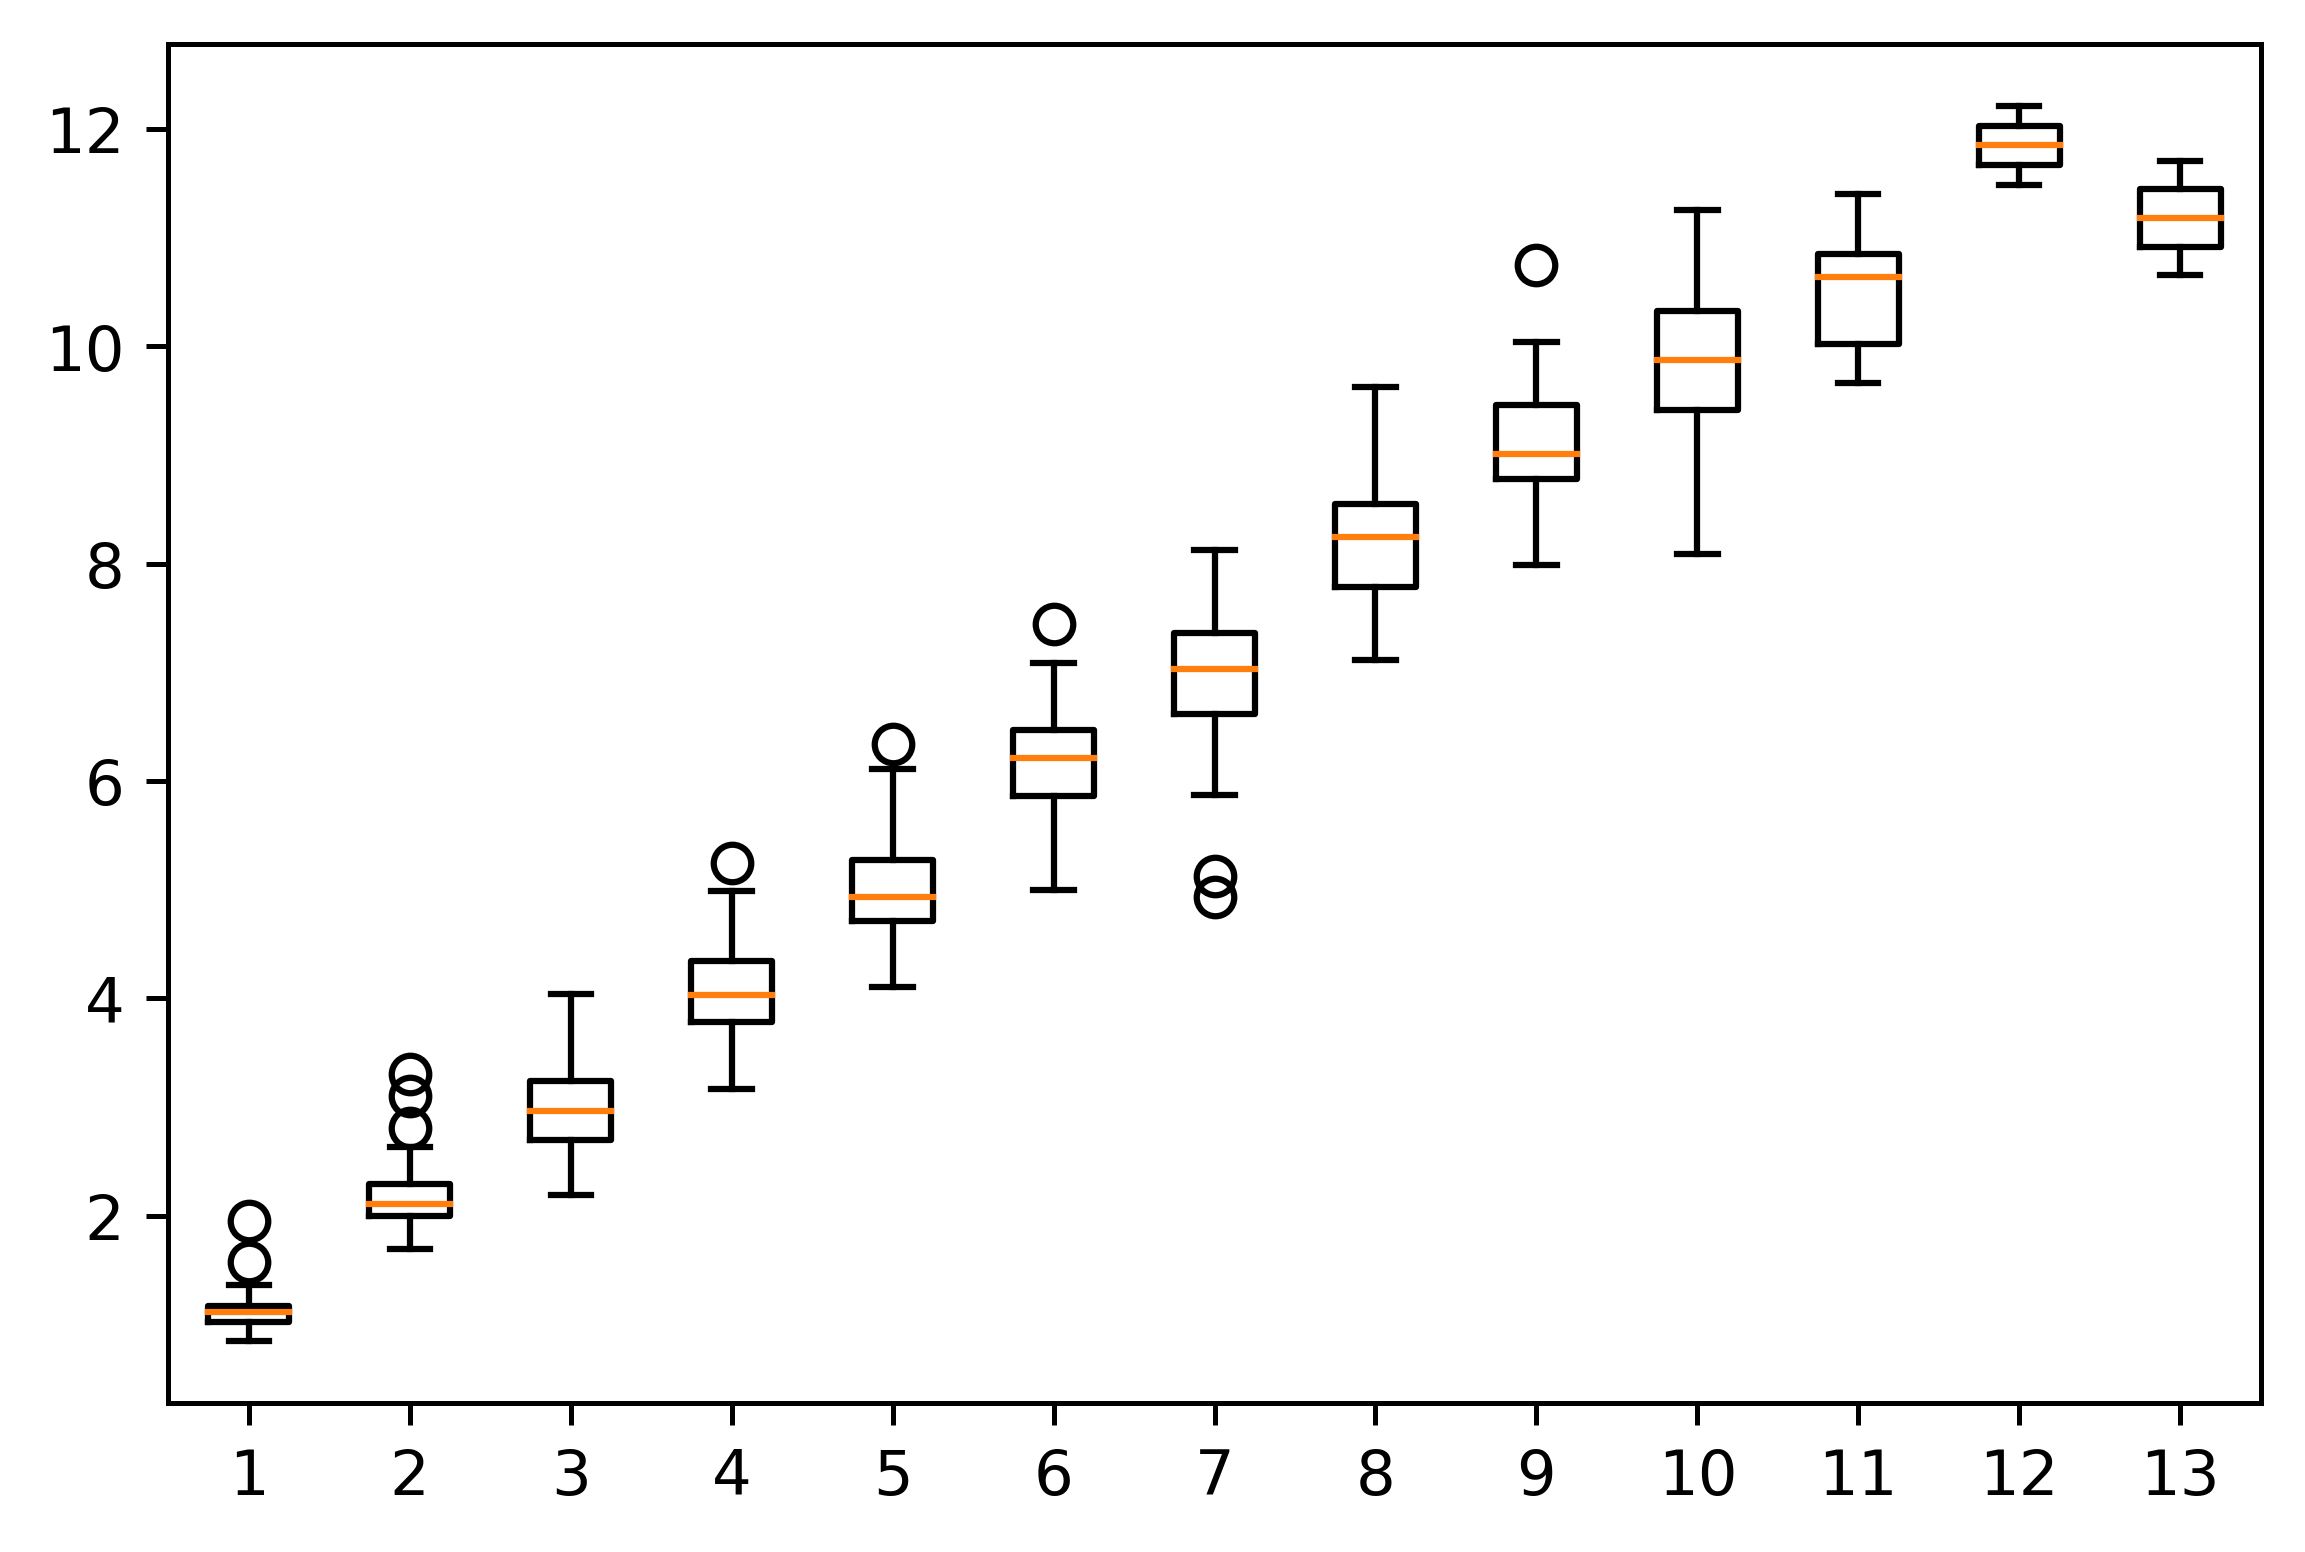

In [9]:
plt.rcParams['figure.dpi'] = 450
x = t[0].y_true
y = aggregate_pred
age_range = np.unique(x)
pr_age_group = []
for i in age_range:
    age_idx = np.where(x == i)
    pr_age_group.append( y[age_idx] )

plt.boxplot(pr_age_group)
plt.show()

### Residual plot per age group

The predictions show heteroskedasticity: heteroskedasticity happens when the standard deviations of a predicted variable, monitored over different values of an independent variable or as related to prior time periods, are non-constant.

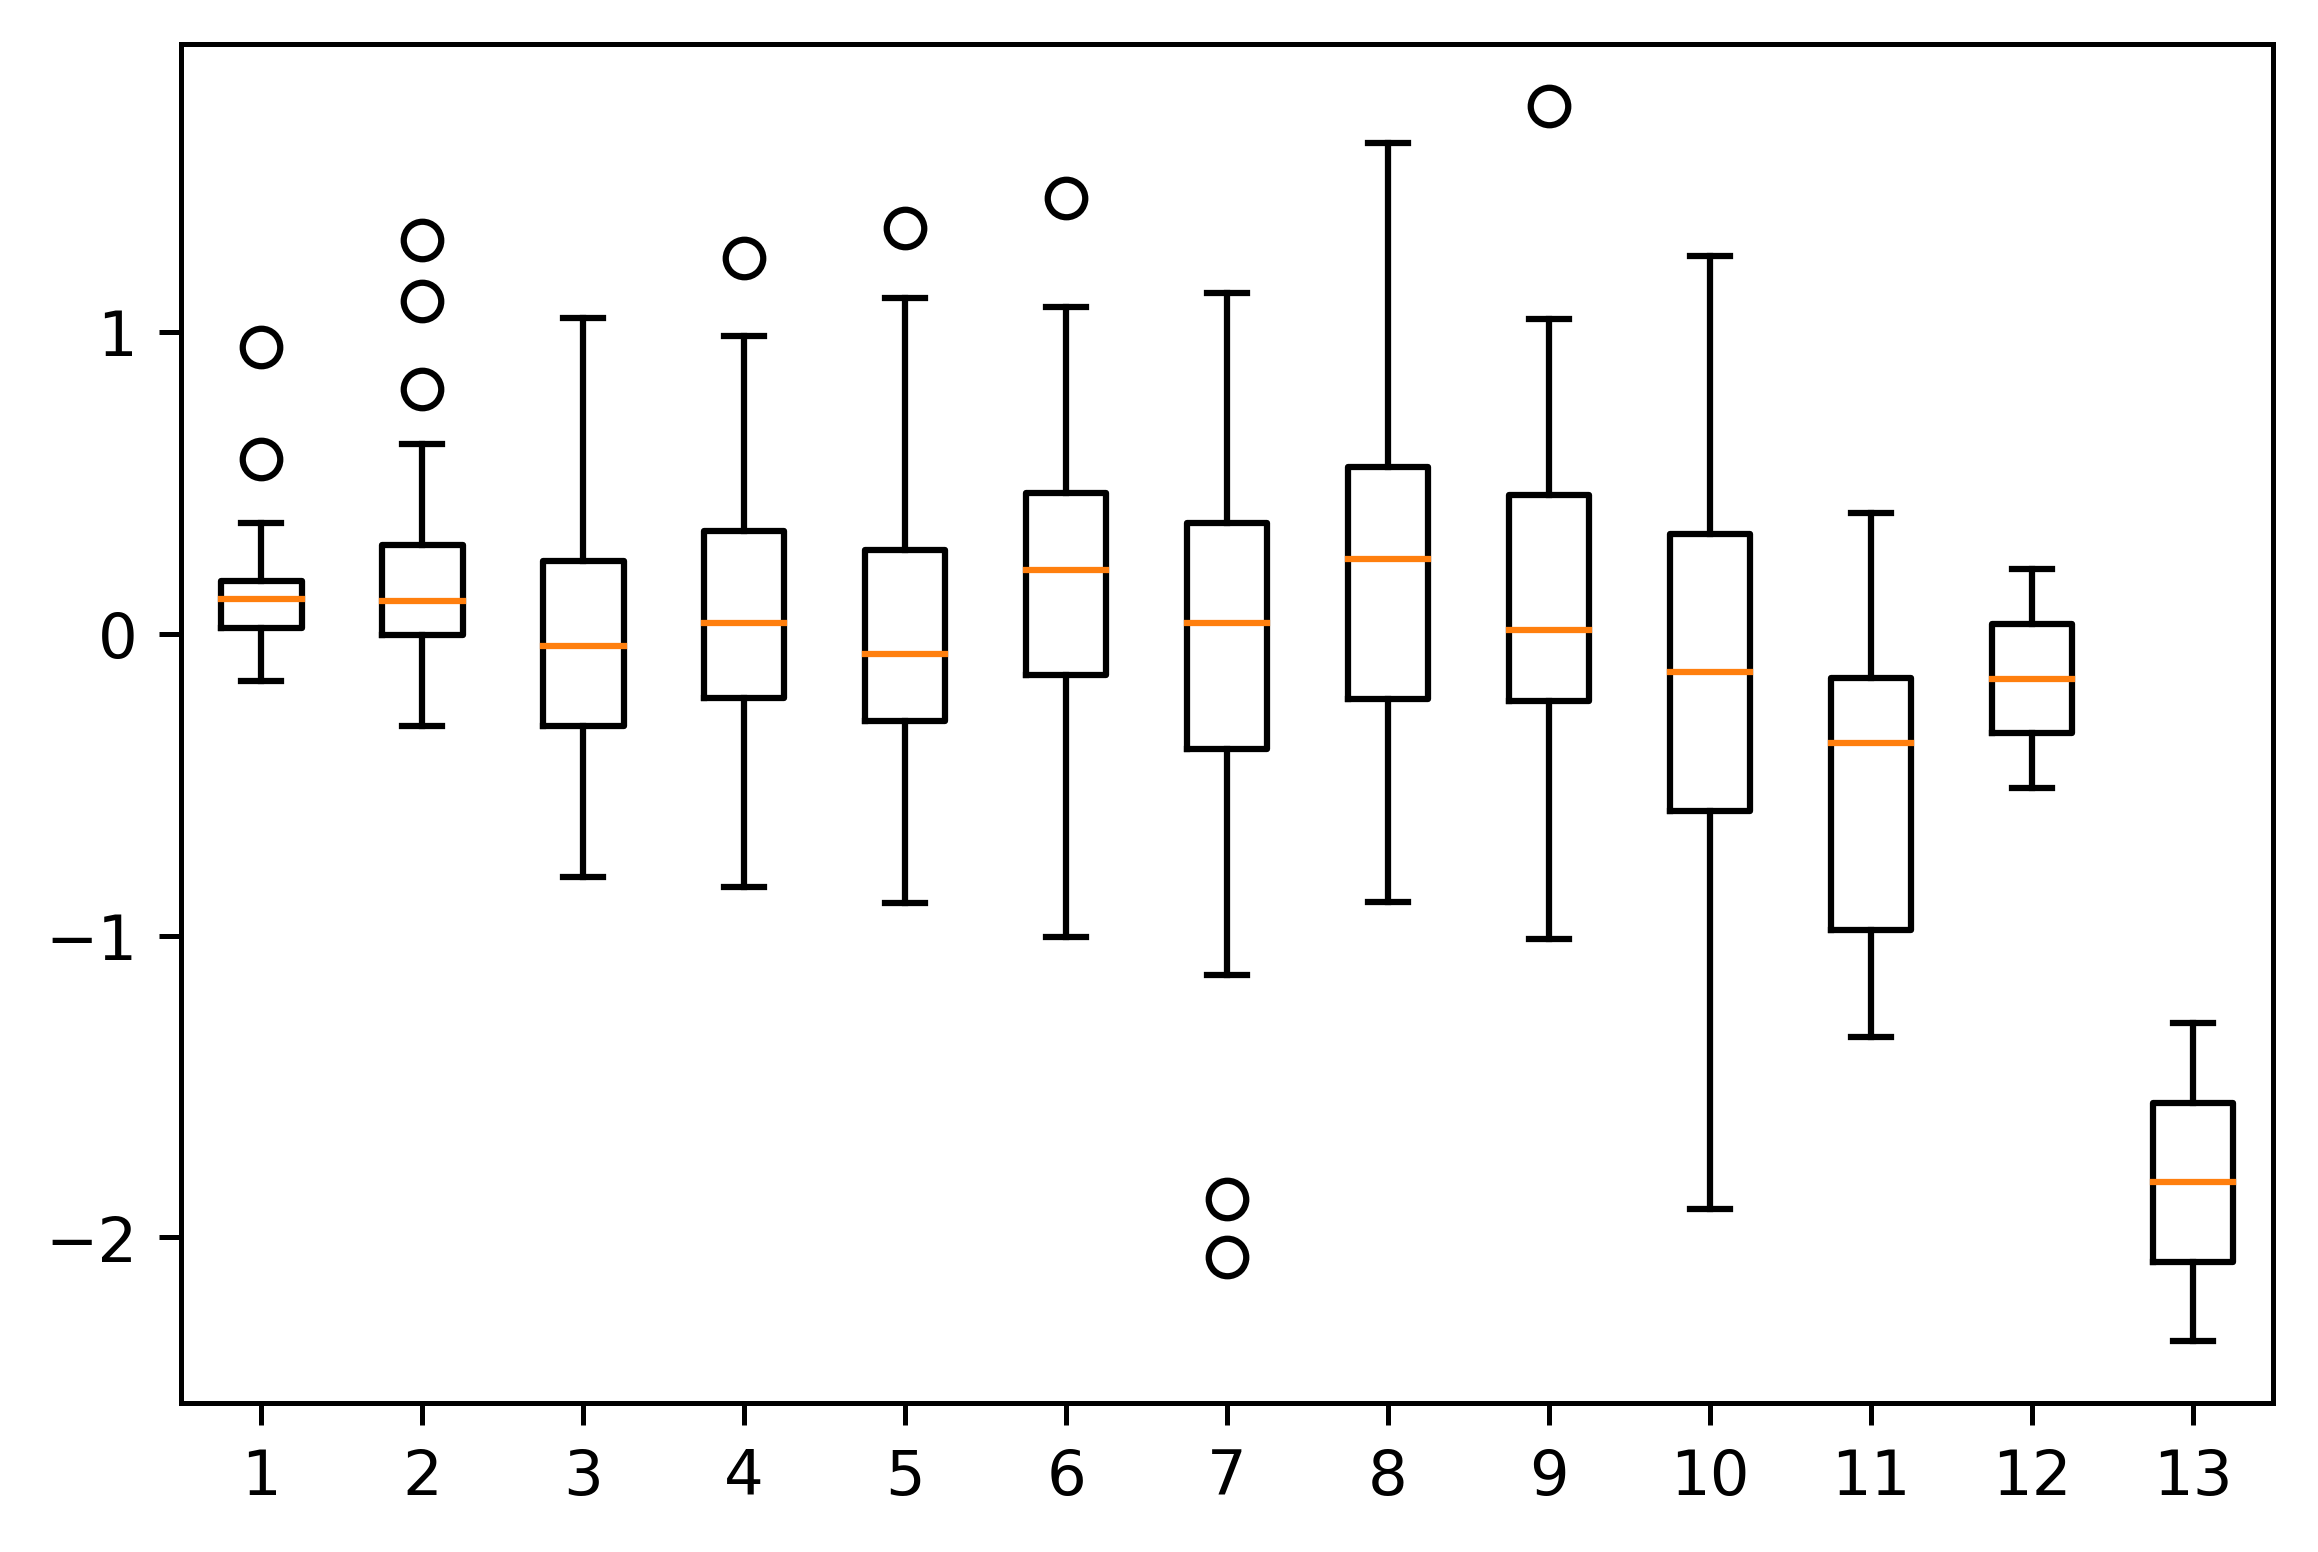

In [10]:
x = t[0].y_true
y = aggregate_pred
age_range = np.unique(x)
pr_age_group = []
for i in age_range:
    age_idx = np.where(x == i)
    pr_age_group.append( y[age_idx] - i )

plt.boxplot(pr_age_group)
plt.show()

### Box plot of mode error summarized over all age groups, and summary statistics

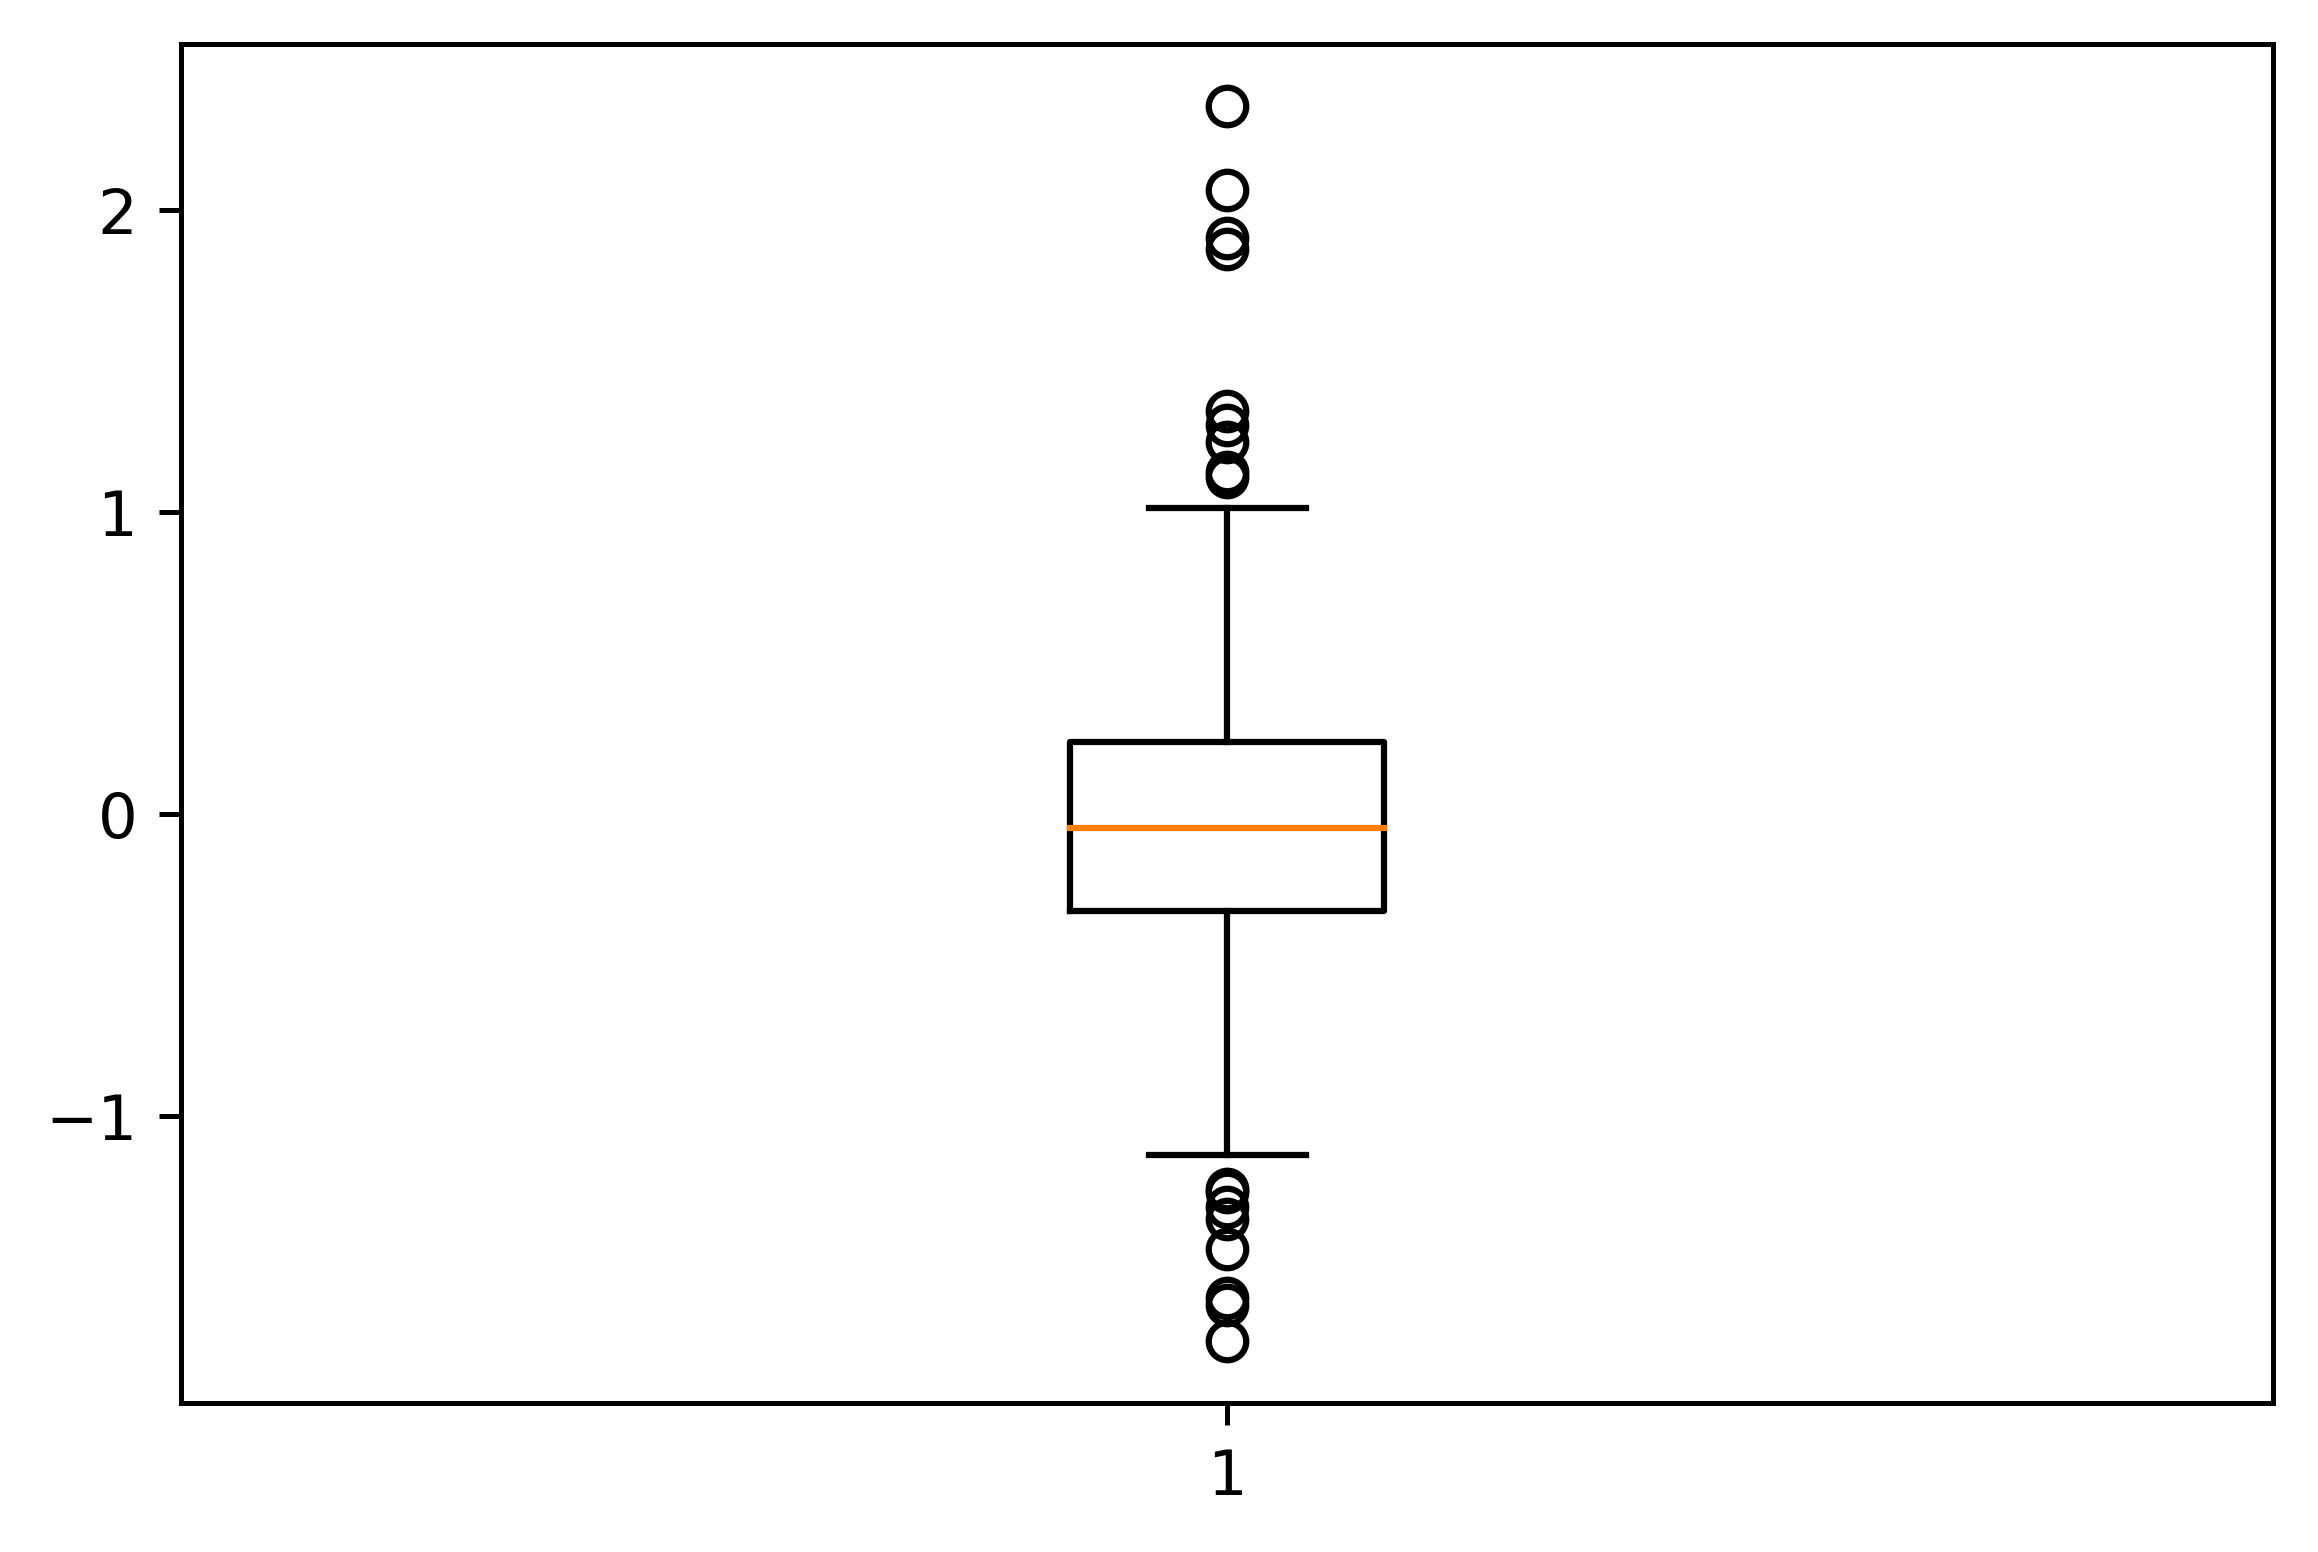

,y_true
count,515.000000
mean,-0.045079
std,0.506820
min,-1.748430
25%,-0.322711
50%,-0.046263
75%,0.237534
max,2.344753


In [11]:
x =  t[0].y_true
y = aggregate_pred
errors = x-y
pr_age_group = []
for i in age_range:
    age_idx = np.where(x == i)
    pr_age_group.append( y[age_idx] - i )

plt.boxplot(errors)
plt.show()


df_describe = pd.DataFrame(errors)
df_describe.describe()

### Scatterplot error predictions after rounding

errors in [0.5, 1.5):  132
errors in [1.5, \inf): 7
Total missclassification errors:139


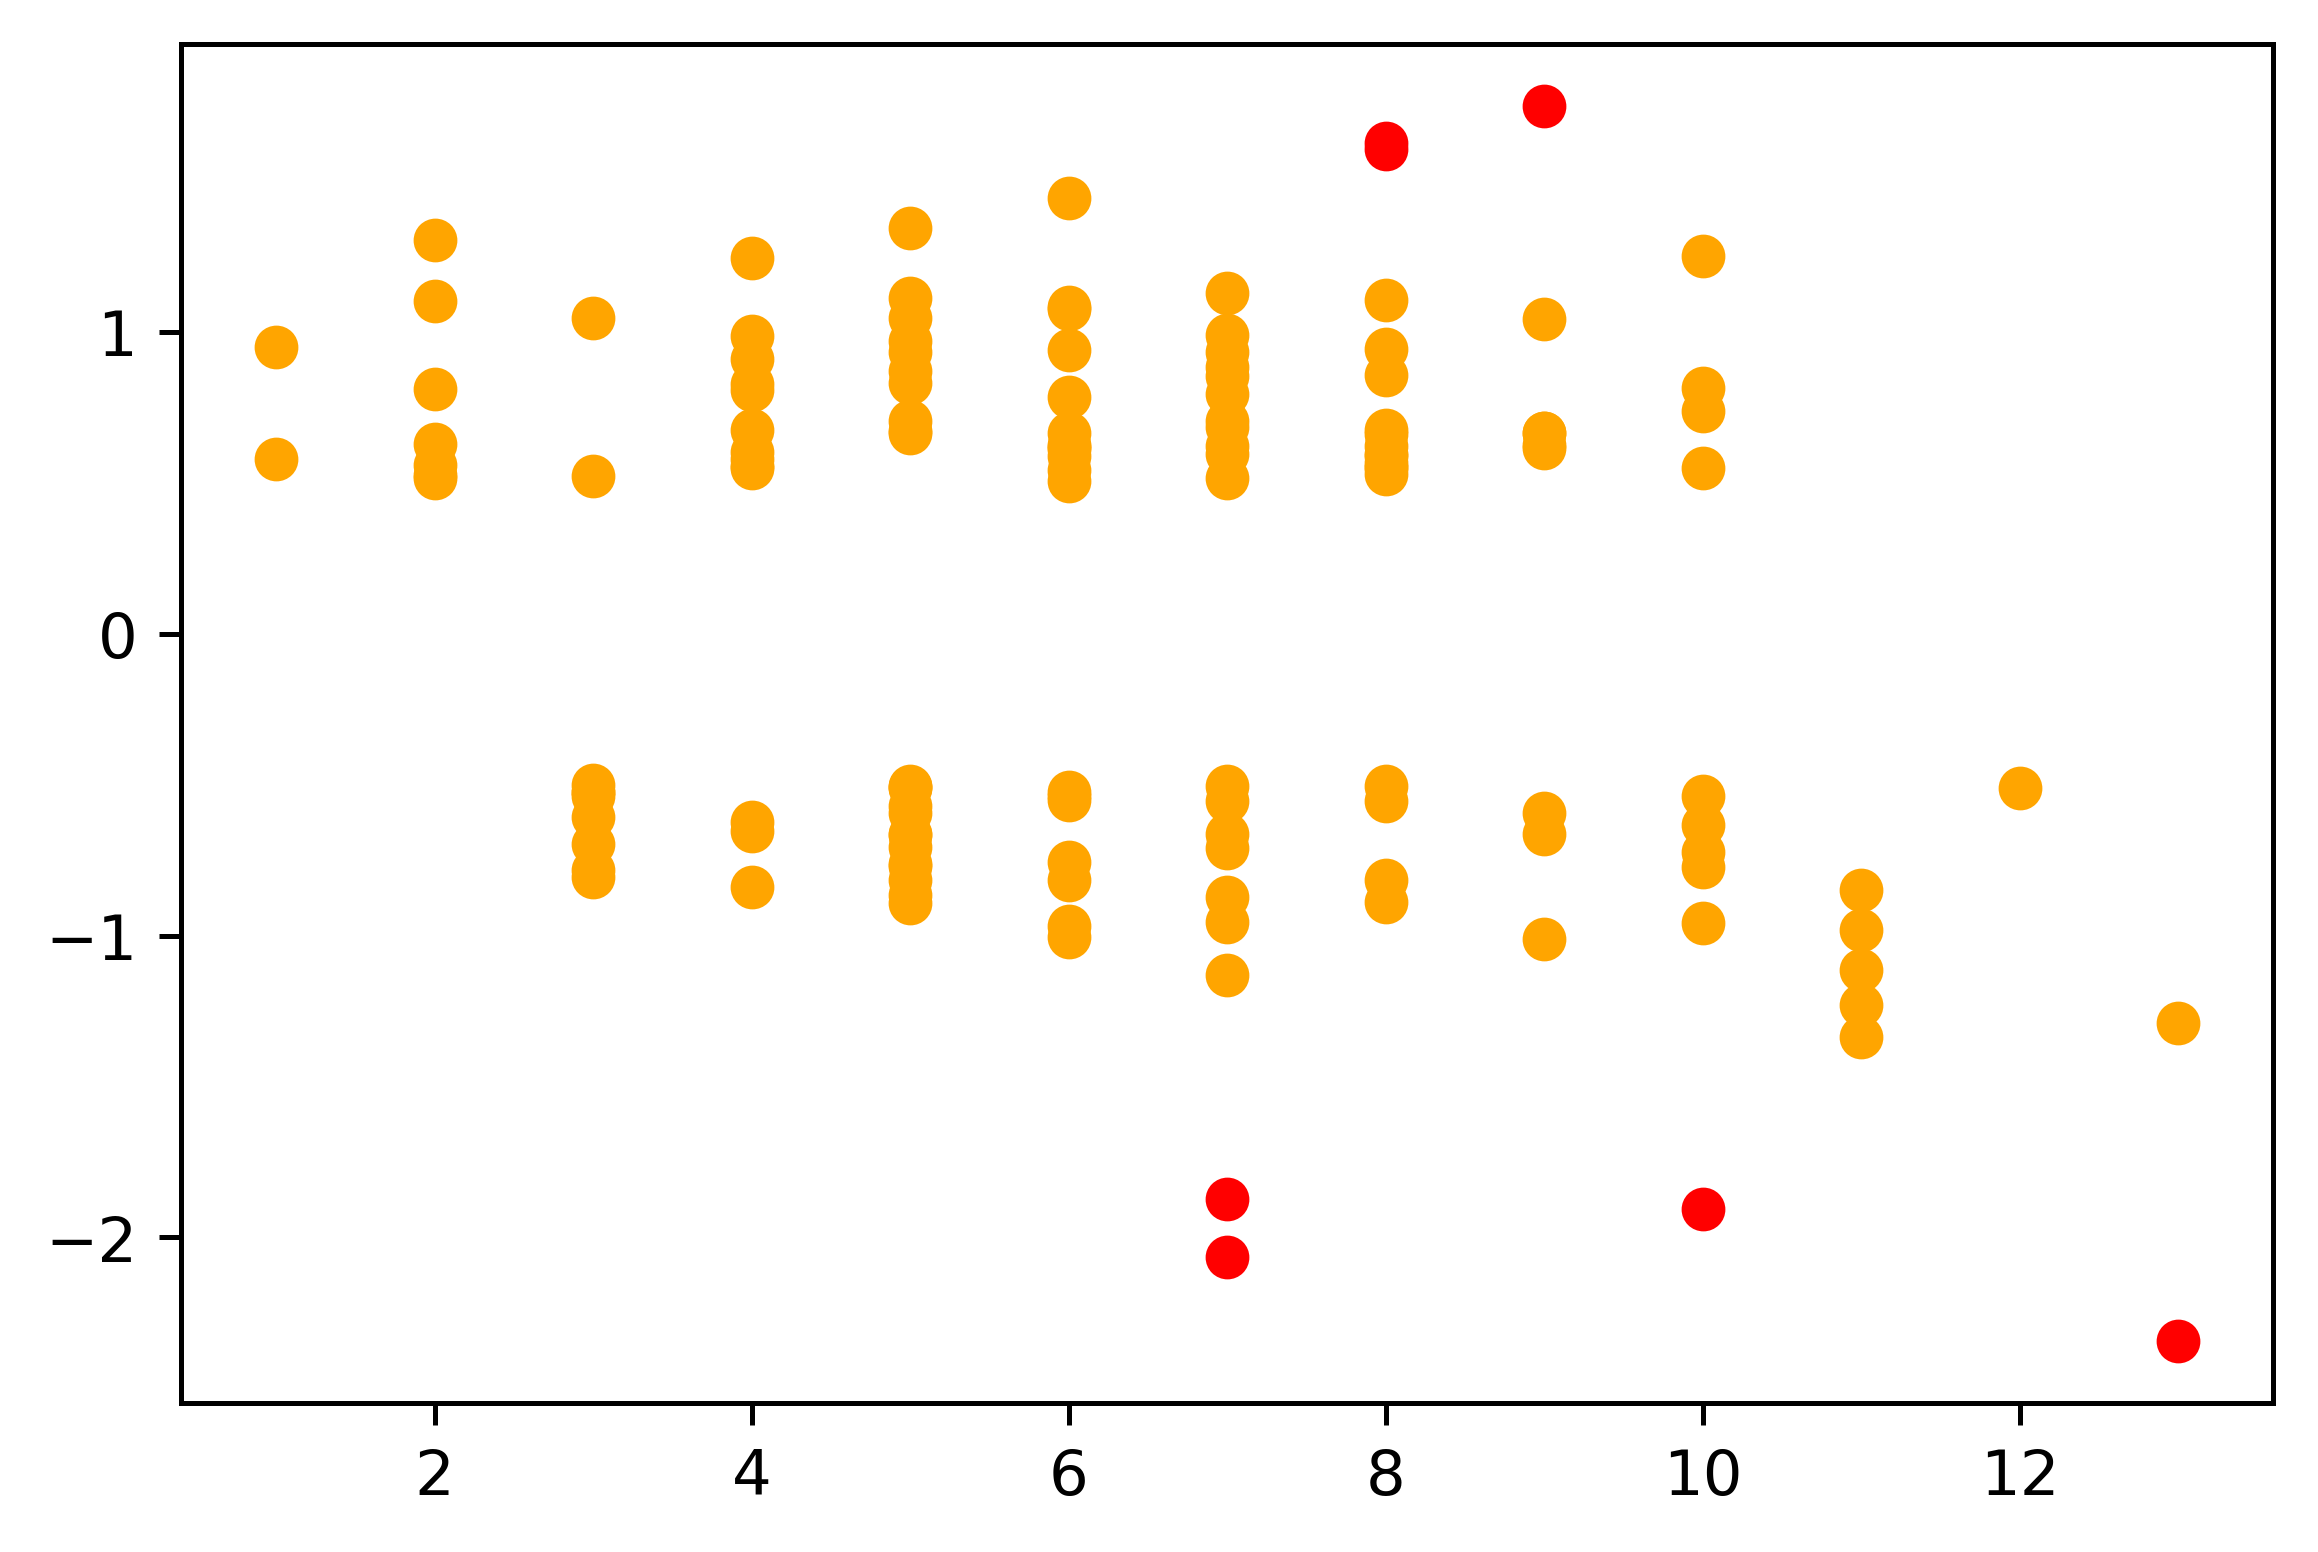

In [12]:
x =  t[0].y_true
y = aggregate_pred
age_range = np.unique(x)
pr_age_group = []
all_rounding_err1 = []
all_rounding_err2 = []
for i in age_range:
    age_idx = np.where(x == i)
    errors = y[age_idx] - i
    errors1 = errors[(np.abs(errors) >= 0.5) & (np.abs(errors) < 1.5)]
    x_axis = [i]*len(errors1)
    plt.scatter(x_axis, errors1, color="orange")
    
    errors2 = errors[np.abs(errors) >= 1.5 ]
    x_axis = [i]*len(errors2)
    plt.scatter(x_axis, errors2, color="red")
    all_rounding_err1.append(errors1)
    all_rounding_err2.append(errors2)
    

flat_list = [item for sublist in all_rounding_err1 for item in sublist]   
oneError = len(flat_list)
print("errors in [0.5, 1.5):  "+ str( oneError ) )

flat_list = [item for sublist in all_rounding_err2 for item in sublist]    
twoOrMore = len(flat_list)
print("errors in [1.5, \inf): "+ str( twoOrMore ) )
print("Total missclassification errors:"+str(oneError+twoOrMore))

plt.show()

### Excluding min/max prediction by fold pr prediction

In [13]:
all_preds = pd.DataFrame()
for i in range(1,10):
  all_preds[str(i)] = t[i].y_pred_test

all_preds.head()
all_preds['new_pred'] =0.0
for index, row in all_preds.iterrows():
    mask = np.logical_or(row == row.max(), row == row.min())
    #print(mask)
    #print(row)
    row_masked = np.ma.masked_array(row, mask = mask)
    #print(row_masked)
    all_preds['new_pred'].iloc[index] = row_masked.mean()
    
all_preds.head()

print("aggregate accuracy, mse")
print(str( accuracy_score(all_preds.new_pred.round().astype("int"), t[0].y_true) )+ " " + 
      str( mean_squared_error(all_preds.new_pred, t[0].y_true) ))

#0.7339805825242719 0.272170267061415

aggregate accuracy, mse
0.7262135922330097 0.2544355976641518


### Outliers >= 1.5 years

In [14]:
test_set_files = pd.read_csv('test_set_files.csv')
x =  t[0].y_true
y = aggregate_pred
age_range = np.unique(x)
for i in age_range:
    age_idx = np.where(x == i)
    for j in age_idx[0]:
        if np.abs( y[ j ] - i ) >= 1.5:
            print(str(y[j])+" "+str(i), end=',')
            print(j)
            #print(test_set_files.iloc[j].path)

4.934588766098022 7,71
5.128395223617554 7,362
9.60469913482666 8,13
9.627245235443116 8,279
10.748430347442627 9,393
8.093134546279908 10,369
10.655246543884278 13,342


In [15]:
paths=test_set_files.iloc[[13,71,270,360,342,369]].path
short_paths = [path_str[-50:] for path_str in paths]
print(short_paths)
print(test_set_files.iloc[0].path)

['sional_Practice/2016/70224/Nr07_age08/IMG_0284.JPG', 'sional_Practice/2014/70111/Nr12_age07/IMG_0230.JPG', 'sional_Practice/2017/71008/Nr47_age10/IMG_0104.JPG', 'sional_Practice/2017/70401/Nr06_age03/IMG_0086.JPG', 'sional_Practice/2016/71014/Nr08_age13/IMG_0044.JPG', 'sional_Practice/2018/71016/Nr05_age10/IMG_0122.JPG']
/gpfs/gpfs0/deep/data/Savannah_Professional_Practice2021_08_12_2021/CodOtholiths-MachineLearning/Savannah_Professional_Practice/2013/70174/Nr06_age09/IMG_0032.JPG
